### 📦 Step 1: Merge Brain Tumor Images into One Folder
We scan all subdirectories to find folders like `brain_glioma` and `brain_menin`,
and copy their files to a single train/test directory based on their parent path.

In [14]:
import os
import shutil

SOURCE_ROOT = "/kaggle/input/brain-tumors"
DEST_ROOT = "/kaggle/working/final_dataset"
os.makedirs(DEST_ROOT, exist_ok=True)

# Walk and copy all glioma/menin from any nested folder
for root, dirs, files in os.walk(SOURCE_ROOT):
    for dirname in dirs:
        if dirname in ['brain_glioma', 'brain_menin']:
            src_dir = os.path.join(root, dirname)

            # Decide if it's train or test based on parent folders
            lower = src_dir.lower()
            if '/train/' in lower:
                subset = 'train'
            elif '/test/' in lower:
                subset = 'test'
            else:
                print(f"⚠️ Skipping: {src_dir} (cannot detect train/test)")
                continue

            # Create destination and copy files
            dest_dir = os.path.join(DEST_ROOT, subset, dirname)
            os.makedirs(dest_dir, exist_ok=True)

            for file in os.listdir(src_dir):
                src_file = os.path.join(src_dir, file)
                dest_file = os.path.join(dest_dir, file)

                # Avoid overwriting
                if os.path.exists(dest_file):
                    base, ext = os.path.splitext(file)
                    count = 1
                    while os.path.exists(dest_file):
                        dest_file = os.path.join(dest_dir, f"{base}_{count}{ext}")
                        count += 1

                shutil.copy2(src_file, dest_file)

print("✅ Done merging.")

✅ Done merging.


### 🔍 Step 2: Verify Image Count After Merge

In [16]:
for subset in ['train', 'test']:
    for label in ['brain_glioma', 'brain_menin']:
        path = f"/kaggle/working/final_dataset/{subset}/{label}"
        count = len(os.listdir(path)) if os.path.exists(path) else 0
        print(f"{subset}/{label}: {count} images")

train/brain_glioma: 1600 images
train/brain_menin: 74 images
test/brain_glioma: 2400 images
test/brain_menin: 114 images


## 📚 Import Required Libraries

Import all necessary libraries for model building, training, evaluation, and visualization.

In [36]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## 🔧 Enhanced Data Preparation

Set up improved data generators with comprehensive augmentation techniques to increase model robustness and prevent overfitting.

**Key Features:**
- Enhanced data augmentation (rotation, zoom, shifts, shear)
- Proper image preprocessing and normalization
- Binary classification setup for Glioma vs Meningioma
- Class information display

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32
train_dir = "/kaggle/working/final_dataset/train"
test_dir = "/kaggle/working/final_dataset/test"

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1./255)

train_loader = train_gen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='binary'
)

test_loader = test_gen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='binary',
    shuffle=False
)

print("Class indices:", train_loader.class_indices)
print("Classes found:", list(train_loader.class_indices.keys()))

Found 1674 images belonging to 2 classes.
Found 2514 images belonging to 2 classes.
Class indices: {'brain_glioma': 0, 'brain_menin': 1}
Classes found: ['brain_glioma', 'brain_menin']


## 🏗️ Build MobileNet Architecture

Create the MobileNet-based model with custom classification head for brain tumor type classification.

**Architecture:**
- Pre-trained MobileNet backbone (ImageNet weights)
- Custom classification head with dropout layers
- Binary output with sigmoid activation (Glioma vs Meningioma)

In [38]:
def create_mobilenet_model(input_shape=(224, 224, 3), num_classes=1):
    base_model = MobileNet(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

model, base_model = create_mobilenet_model()

## ⚙️ Model Compilation and Summary

Compile the model with appropriate optimizer, loss function, and metrics. Display model architecture summary.

**Configuration:**
- Optimizer: Adam (lr=0.001)
- Loss: Binary crossentropy
- Metrics: Accuracy

In [42]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("Model Summary:")
model.summary()

Model Summary:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,885,249 (14.82 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

## 🎯 Define Training Callbacks

Set up callbacks for training optimization and model monitoring.

**Callbacks:**
- **EarlyStopping**: Prevent overfitting
- **ReduceLROnPlateau**: Adaptive learning rate

In [43]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

## 🚀 Model Training - Transfer Learning

Train the model with frozen MobileNet layers, focusing on learning the classification head for optimal performance.

**Training Strategy:**
- Freeze all MobileNet layers (transfer learning)
- Train only the custom classification head
- Extended training epochs for better convergence
- Efficient training without overfitting

In [44]:
print("=== Training with frozen MobileNet layers ===")
history = model.fit(
    train_loader,
    epochs=15,
    validation_data=test_loader,
    callbacks=callbacks,
    verbose=1
)

=== Training with frozen MobileNet layers ===
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9560 - loss: 0.1911 - val_accuracy: 0.9793 - val_loss: 0.0477 - learning_rate: 0.0010
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9761 - loss: 0.0551 - val_accuracy: 0.9857 - val_loss: 0.0375 - learning_rate: 0.0010
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9757 - loss: 0.0512 - val_accuracy: 0.9881 - val_loss: 0.0363 - learning_rate: 0.0010
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9846 - loss: 0.0425 - val_accuracy: 0.9881 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9836 - loss: 0.0469 - val_accuracy: 0.9905 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9844 - loss: 0.0395 - val_accuracy: 0.9881 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - 

## 📈 Visualize Training Progress

Create comprehensive plots showing model performance across all metrics throughout training.

**Visualizations:**
- Training/Validation Accuracy
- Training/Validation Loss
- Precision and Recall trends
- Complete training history analysis

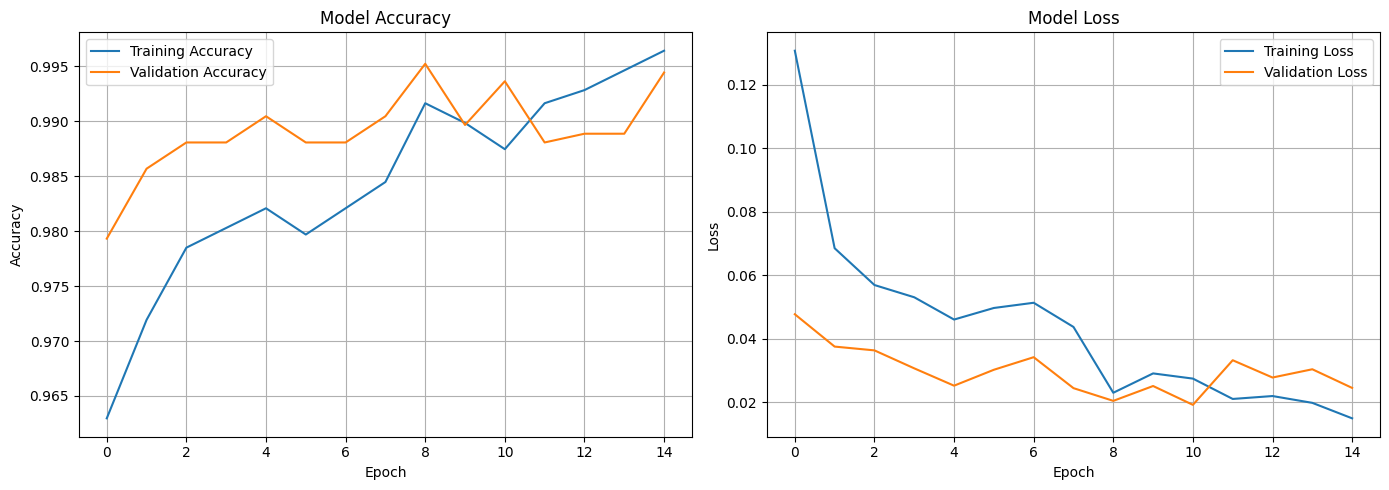

In [52]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy Plot
    axes[0].plot(history['accuracy'], label='Training Accuracy')
    axes[0].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss Plot
    axes[1].plot(history['loss'], label='Training Loss')
    axes[1].plot(history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history.history)

## 🔍 Model Performance Evaluation

Evaluate the final model performance on test data with comprehensive metrics.

**Evaluation Metrics:**
- Test Accuracy
- Precision and Recall
- F1-Score calculation
- Overall model performance summary

In [54]:
print("=== Model Evaluation ===")
test_loss, test_accuracy = model.evaluate(test_loader, verbose=1)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

=== Model Evaluation ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 704ms/step - accuracy: 0.9958 - loss: 0.0104
Test Accuracy: 0.9936
Test Loss: 0.0191


## 📋 Generate Predictions and Classification Report

Create detailed predictions and classification report for comprehensive model analysis.

**Analysis:**
- Generate predictions on test set
- Create classification report
- Analyze model performance per class

In [55]:
predictions = model.predict(test_loader)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_loader.classes

print("=== Classification Report ===")
class_names = list(test_loader.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 707ms/step
=== Classification Report ===
              precision    recall  f1-score   support

brain_glioma       1.00      1.00      1.00      2400
 brain_menin       0.93      0.93      0.93       114

    accuracy                           0.99      2514
   macro avg       0.96      0.96      0.96      2514
weighted avg       0.99      0.99      0.99      2514



## 🎨 Confusion Matrix Visualization

Create and visualize confusion matrix to understand model's classification performance.

**Confusion Matrix Benefits:**
- Visual representation of classification accuracy
- Identify false positives and false negatives
- Understand model's classification patterns

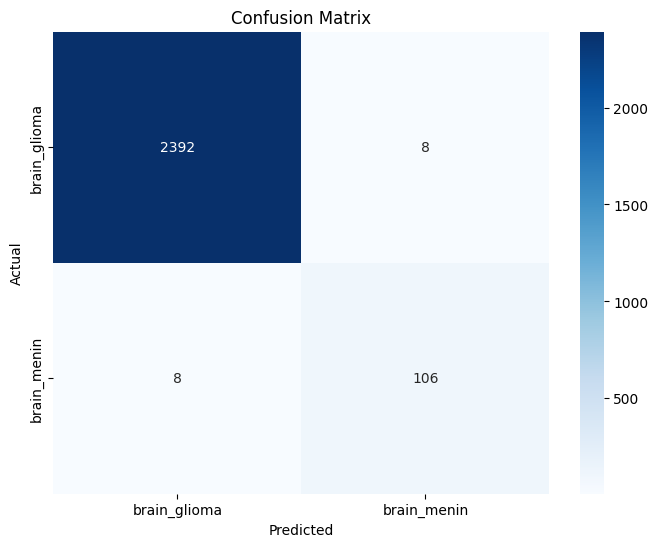

In [56]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 🔮 Create Prediction Function

Develop a utility function for making predictions on new brain scan images to classify tumor types.

**Prediction Function Features:**
- Load and preprocess new images
- Generate confidence scores
- Return human-readable results (Glioma or Meningioma)
- Easy integration for deployment

In [60]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_brain_tumor_type(model, image_path):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)[0][0]
    
    if prediction > 0.5:
        label = f"Meningioma (Confidence: {prediction:.2f})"
    else:
        label = f"Glioma (Confidence: {1 - prediction:.2f})"
    
    return label, img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


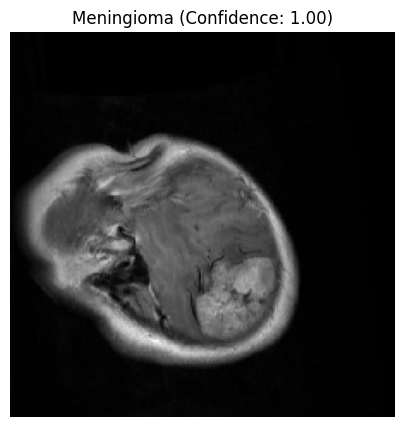

In [62]:
# Example usage
image_path = "/kaggle/input/brain-tumors/test/test/brain_menin/brain_menin_0111.jpg"
result_text, img_pil = predict_brain_tumor_type(model, image_path)

# Plot the image with the predicted label
plt.figure(figsize=(5, 5))
plt.imshow(img_pil)
plt.title(result_text)
plt.axis('off')
plt.show()